In [1]:
import sys, os
import numpy as np
import h5py as h5
import ROOT as rt

Welcome to JupyROOT 6.22/08


In [2]:
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import qol_util as qu

In [3]:
colors = {
    'constituents': rt.kRed,
    'top': rt.kGreen,
    'bottom': rt.kOrange,
    'W': rt.kBlue
}

In [4]:
filename = '../events.h5'
f = h5.File(filename,'r')

top = f['truth_Pdg'][:] == 6
bottom = f['truth_Pdg'][:] == 5
W = f['truth_Pdg'][:] == 24


nobj = f['Nobj'][:]

E = {
    'constituents':f['Pmu'][:,:,3].flatten(),
    'top':f['truth_Pmu'][:][top][:,3].flatten(),
    'bottom':f['truth_Pmu'][:][bottom][:,3].flatten(),
    'W':f['truth_Pmu'][:][W][:,3].flatten(),
}

px = {
    'constituents': f['Pmu'][:,:,0].flatten(),
    'top':f['truth_Pmu'][:][top][:,0].flatten(),
    'bottom':f['truth_Pmu'][:][bottom][:,0].flatten(),
    'W':f['truth_Pmu'][:][W][:,0].flatten(),
}

py = {
    'constituents': f['Pmu'][:,:,1].flatten(),
    'top':f['truth_Pmu'][:][top][:,1].flatten(),
    'bottom':f['truth_Pmu'][:][bottom][:,1].flatten(),
    'W':f['truth_Pmu'][:][W][:,1].flatten(),
}

pz = {
    'constituents': f['Pmu'][:,:,2].flatten(),
    'top':f['truth_Pmu'][:][top][:,2].flatten(),
    'bottom':f['truth_Pmu'][:][bottom][:,2].flatten(),
    'W':f['truth_Pmu'][:][W][:,2].flatten(),
}

pt = {key: np.sqrt(px[key] * px[key] + py[key] * py[key]) for key in E.keys()}
p2 = {key: px[key] * px[key] + py[key] * py[key] + pz[key] * pz[key] for key in E.keys()}
m = {key: np.sqrt((E[key] * E[key] - p2[key]).clip(min=0)) for key in E.keys()}

f.close()

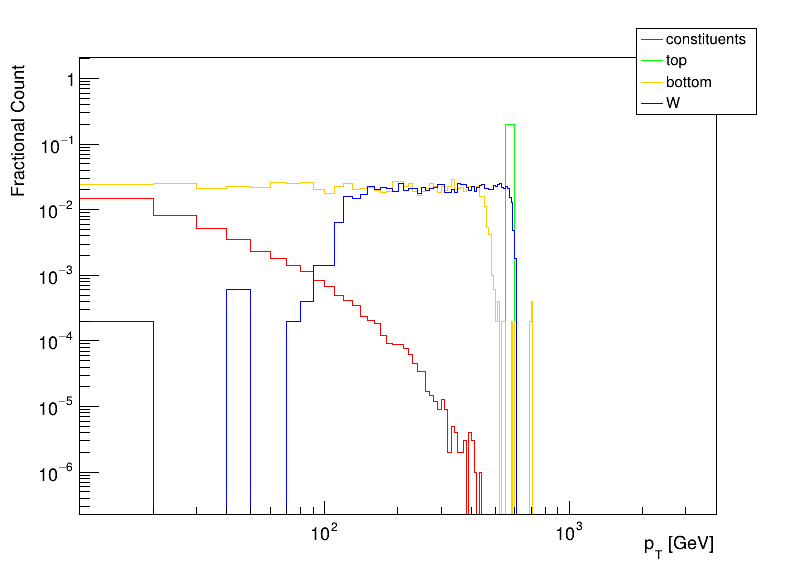

In [26]:
c = rt.TCanvas(qu.RN(),'c1',800,600)
legend = rt.TLegend(0.8,0.8,0.95,0.95)
hists = []
hstack = rt.THStack(qu.RN(),';p_{T} [GeV];Fractional Count')

nbins = 400
xmin = 0.
xmax = 4000.

for key in E.keys():
    
    h = rt.TH1F(qu.RN(),'',nbins,xmin,xmax)
    for elem in pt[key]: h.Fill(elem)
    h.SetLineColor(colors[key])
    integral = np.maximum(h.Integral(),1.)
    h.Scale(1./integral)
    hstack.Add(h)
    legend.AddEntry(h,key,'l')
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
legend.Draw()
c.SetLogx()
c.SetLogy()
c.Draw()

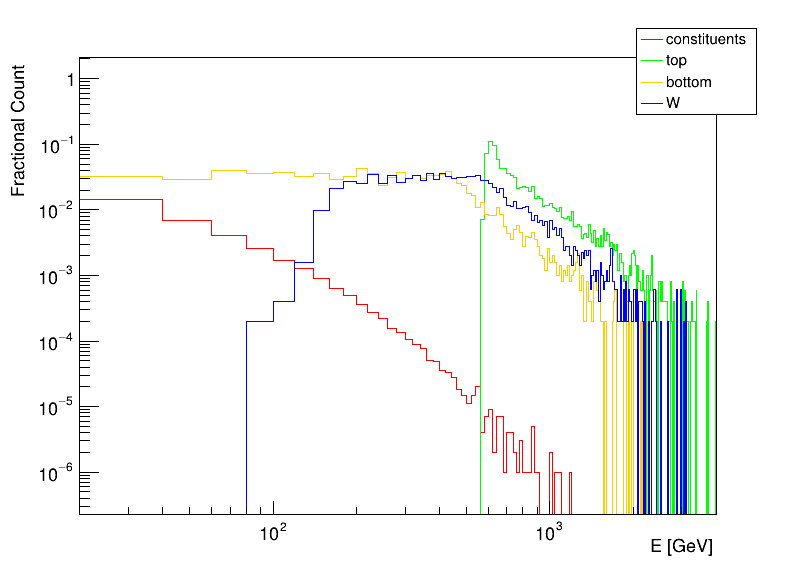

In [24]:
c = rt.TCanvas(qu.RN(),'c2',800,600)
legend = rt.TLegend(0.8,0.8,0.95,0.95)
hists = []
hstack = rt.THStack(qu.RN(),';E [GeV];Fractional Count')

nbins = 200
xmin = 0.
xmax = 4000.

for key in E.keys():
    
    h = rt.TH1F(qu.RN(),'',nbins,xmin,xmax)
    for elem in E[key]: h.Fill(elem)
    h.SetLineColor(colors[key])
    integral = np.maximum(h.Integral(),1.)
    h.Scale(1./integral)
    hstack.Add(h)
    legend.AddEntry(h,key,'l')
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
legend.Draw()
c.SetLogx()
c.SetLogy()
c.Draw()

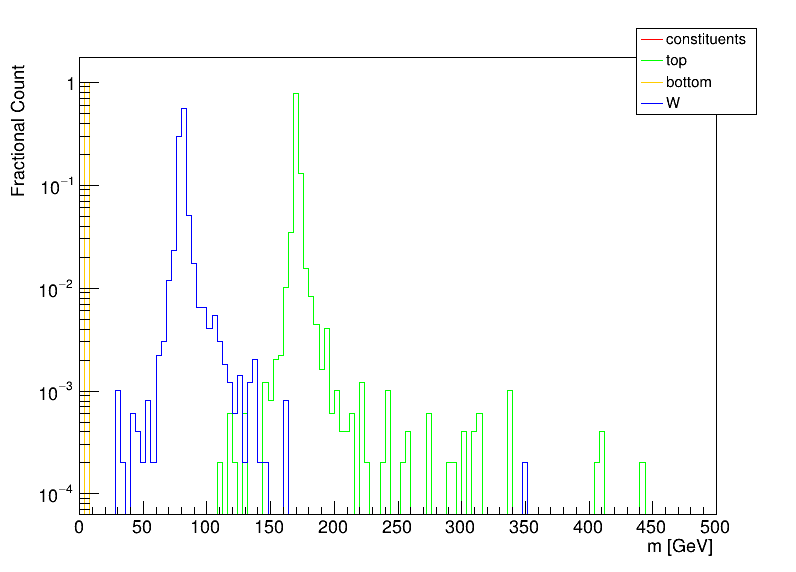

In [32]:
c = rt.TCanvas(qu.RN(),'c2',800,600)
legend = rt.TLegend(0.8,0.8,0.95,0.95)
hists = []
hstack = rt.THStack(qu.RN(),';m [GeV];Fractional Count')

nbins = 125
xmin = 0.
xmax = 500.

for key in E.keys():
    
    h = rt.TH1F(qu.RN(),'',nbins,xmin,xmax)
    for elem in m[key]: h.Fill(elem)
    h.SetLineColor(colors[key])
    integral = np.maximum(h.Integral(),1.)
    h.Scale(1./integral)
    hstack.Add(h)
    legend.AddEntry(h,key,'l')
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
legend.Draw()
c.SetLogy()
c.Draw()